In [1]:
import boto3
import json
import base64
from io import BytesIO
from IPython.display import Image, display

In [2]:
# Initialize the Amazon Bedrock client
bedrock = boto3.client('bedrock-runtime')

In [3]:
def get_stylist_recommendation(occasion, gender):
    # Step 1: Text-based outfit suggestion
    prompt_text = f"Human: I am attending a {occasion} and I am {gender}. What outfit would you suggest?\nAssistant:"

    # Define the payload for invoking the model
    payload = {
        "prompt": prompt_text,              # Use 'prompt' with the correct Human-Assistant conversation format
        "max_tokens_to_sample": 200         # Adjust max tokens as needed for Claude
    }
    
    # Call Claude model for text-based recommendation
    suggestion_response = bedrock.invoke_model(
        modelId='anthropic.claude-v2:1',       # Use Claude, or 'ai21.jurassic-2' for Jurassic
        contentType='application/json',
        body=json.dumps(payload).encode('utf-8')  # Properly encode the payload as JSON
    )

    # Extract the outfit suggestion text
    suggestion = suggestion_response['body'].read().decode('utf-8')

    # Step 2: Image generation or retrieval based on the suggestion
    prompt_image = f"An outfit that matches the following description: {suggestion}"

    # Call Stability AI (Stable Diffusion) model for image generation
    stable_diffusion_payload = {
        "text_prompts": [{"text": prompt_image}],
        "cfg_scale": 7,
        "steps": 50,
        "seed": 0
    }

    try:
        image_response = bedrock.invoke_model(
            modelId='stability.stable-diffusion-xl-v1',
            contentType='application/json',
            body=json.dumps(stable_diffusion_payload)
        )
        
        image_result = json.loads(image_response['body'].read())
        
        # Extract the base64 encoded image
        image_suggestions = image_result['artifacts'][0]['base64']

        # Add padding if necessary
        image_suggestions += '=' * (-len(image_suggestions) % 4)

    except Exception as e:
        print(f"Error generating image: {str(e)}")
        image_suggestions = None
    
    # Return both the text suggestion and the image suggestions
    result = {
        'text_suggestion': suggestion,
        'image_suggestions': image_suggestions
    }

    return result

What is the occasion? (e.g., wedding, casual outing, formal event):  baby shower
What is your gender? (e.g., male, female, non-binary):  female


Outfit Suggestion: {"type":"completion","completion":" Here are some suggested outfits to wear to a baby shower as a female guest:\n\n- A casual dress in a bright, cheerful color or pastel. A knee-length dress or sundress works well. Pair it with neutral sandals or wedges.\n\n- A nice top (such as a blouse or sweater) with dress pants or a skirt. Opt for lighter colors or floral prints. A pantsuit can also work well.\n\n- Dark jeans paired with a colorful blouse or nicer top. Make it dressier with some simple jewelry and heels or booties.\n\n- If it's more of a casual shower, something like a maxi skirt with a tank top or blouse can work. You could also do jeans with a floral top or sweater.\n\nSome additional tips:\n\n- Feel free to incorporate \"baby\" elements like prints with storks, onesies, teddy bears, etc. But don't go overboar","stop_reason":"max_tokens","stop":null}


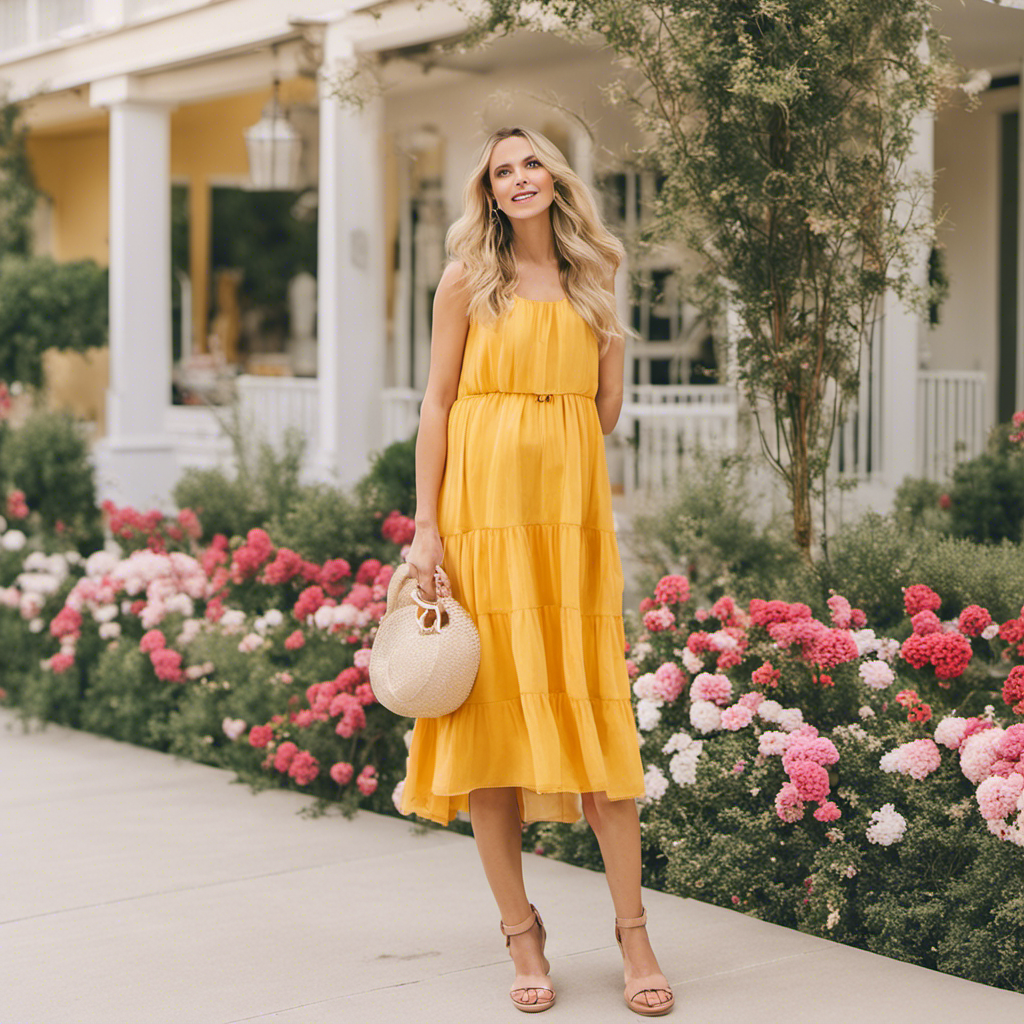

In [4]:
# Example usage
if __name__ == "__main__":
    # Collect input from the user
    occasion = input("What is the occasion? (e.g., wedding, casual outing, formal event): ")
    gender = input("What is your gender? (e.g., male, female, non-binary): ")

    # Generate and display the style suggestion
    stylist_result = get_stylist_recommendation(occasion, gender)
    # Output the final recommendations
    print("Outfit Suggestion:", stylist_result['text_suggestion'])
    # Display the image
    if stylist_result['image_suggestions']:
        try:
            image_data = base64.b64decode(stylist_result['image_suggestions'])
            image = Image(data=image_data)
            display(image)
        except Exception as e:
            print(f"Error displaying image: {str(e)}")
            print("Raw base64 data:", stylist_result['image_suggestions'][:100] + "...") # Print first 100 characters
    else:
        print("No image generated")
